In [ ]:
!pip install googletrans==3.1.0a0
!pip install py_vncorenlp
!pip install fairseq
!pip install fastbpe

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 10.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16351 sha256=a15690e2bdb927260143f04c363bf1550175ef57ed276982a0de94ac1ecb5d3a
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling 

In [ ]:
!wget https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
!tar -xzvf PhoBERT_base_fairseq.tar.gz

--2023-11-27 12:52:01--  https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
Resolving public.vinai.io (public.vinai.io)... 18.160.41.51, 18.160.41.77, 18.160.41.47, ...
Connecting to public.vinai.io (public.vinai.io)|18.160.41.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1243308020 (1.2G) [application/x-tar]
Saving to: ‘PhoBERT_base_fairseq.tar.gz’

PhoBERT_base_fairse 100%[===================>]   1.16G   264MB/s    in 4.6s    

2023-11-27 12:52:06 (259 MB/s) - ‘PhoBERT_base_fairseq.tar.gz’ saved [1243308020/1243308020]

PhoBERT_base_fairseq/
PhoBERT_base_fairseq/bpe.codes
PhoBERT_base_fairseq/model.pt
PhoBERT_base_fairseq/dict.txt


In [ ]:
import pandas as pd
from googletrans import Translator
from transformers import AutoModel, AutoTokenizer
import torch
import random
import fairseq
import os
import py_vncorenlp
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
path = "/absolute/path/to/vncorenlp"

# Kiểm tra xem đường dẫn đã tồn tại chưa
if not os.path.exists(path):
    # Nếu chưa tồn tại, tạo đường dẫn
    os.makedirs(path)
# Automatically download VnCoreNLP components from the original repository
# and save them in some local working folder
py_vncorenlp.download_model(save_dir='/absolute/path/to/vncorenlp')
#Dùng để xử lí dữ liệu cho PhoBERT
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/absolute/path/to/vncorenlp')


In [ ]:
def word_mask(text):
  sentences = rdrsegmenter.word_segment(text)

  # Tokenize mỗi câu
  words = [word for sentence in sentences for word in sentence.split()]

  mask_token = ' <mask>'

  # Chọn ngẫu nhiên một chỉ số từ để mask, không chọn dấu câu
  word_indices = [i for i, word in enumerate(words) if word not in string.punctuation]
  mask_index = random.choice(word_indices)

  # Thay thế từ được chọn bằng mask token
  words[mask_index] = mask_token

  # Ghép lại các từ thành tài liệu
  masked_text = ' '.join(words)

  return masked_text

In [ ]:
# Load PhoBERT-base in fairseq
from fairseq.models.roberta import RobertaModel
bpe_codes_file = '/content/PhoBERT_base_fairseq/bpe.codes'
phobert = RobertaModel.from_pretrained('/content/PhoBERT_base_fairseq', checkpoint_file='model.pt', bpe='fastbpe', bpe_codes=bpe_codes_file).eval()

In [ ]:
def fill_mask(text):
  # Filling marks
  topk_filled_outputs = phobert.fill_mask(text, topk=5)

  sentences = [item[0].replace('_', ' ') for item in topk_filled_outputs]

  return sentences

In [ ]:
text = 'Đội ngũ bảo trì quá thưa thớt dẫn đến không đảm bảo được chất lượng sửa chữa thiết bị.'
text_mask = word_mask(text)

print(text_mask)
print('\n', phobert.fill_mask(text_mask, topk=5))
print('\n', fill_mask(text_mask))

Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đảm_bảo  <mask> chất_lượng sửa_chữa thiết_bị .

 [('Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đảm_bảo được chất_lượng sửa_chữa thiết_bị .', 0.8430072069168091, 'được'), ('Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đảm_bảo về chất_lượng sửa_chữa thiết_bị .', 0.05282580852508545, 'về'), ('Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đảm_bảo tiêu_chuẩn chất_lượng sửa_chữa thiết_bị .', 0.025715304538607597, 'tiêu_chuẩn'), ('Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đảm_bảo yêu_cầu chất_lượng sửa_chữa thiết_bị .', 0.023050609976053238, 'yêu_cầu'), ('Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đảm_bảo nổi chất_lượng sửa_chữa thiết_bị .', 0.005520341452211142, 'nổi')]

 ['Đội ngũ bảo trì quá thưa thớt dẫn đến không đảm bảo được chất lượng sửa chữa thiết bị .', 'Đội ngũ bảo trì quá thưa thớt dẫn đến không đảm bảo về chất lượng sửa chữa thiết bị .', 'Đội ngũ bảo trì quá thưa thớt dẫn đến không đảm bảo tiêu chuẩn chất lượng sửa chữa thiết bị .', 'Đ

In [ ]:
# Khởi tạo dịch giả
translator = Translator()

def translate_back(sentence):
    # Dịch câu sang tiếng Trung
    translated_zh = translator.translate(sentence, src='vi', dest='zh-cn')
    # Dịch ngược câu từ tiếng Trung về tiếng Anh
    translated_en = translator.translate(translated_zh.text, src='zh-cn', dest='en')
    # Dịch ngược câu từ tiếng Anh về tiếng Việt
    translated_vi = translator.translate(translated_en.text, src='en', dest='vi')

    return translated_vi.text

In [ ]:
text = 'Đội ngũ bảo trì quá thưa thớt dẫn đến không đảm bảo được chất lượng sửa chữa thiết bị.'
# Dịch câu sang tiếng Trung
translated_zh = translator.translate(text, src='vi', dest='zh-cn')
# Dịch ngược câu từ tiếng Trung về tiếng Anh
translated_en = translator.translate(translated_zh.text, src='zh-cn', dest='en')
# Dịch ngược câu từ tiếng Anh về tiếng Việt
translated_vi = translator.translate(translated_en.text, src='en', dest='vi')

print(translated_zh.text)
print('\n', translated_en.text)
print('\n', translated_vi.text)

维修队伍过于稀疏，导致无法保证设备维修质量。

 The maintenance team is too sparse, making it impossible to guarantee the quality of equipment maintenance.

 Đội ngũ bảo trì quá thưa nên không thể đảm bảo chất lượng bảo trì thiết bị.


#Augment


## Vietnamese Students’ Feedback Corpus (UIT-VSFC)

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/UDDLL/Data/Vietnamese Students’ Feedback Corpus (UIT-VSFC)/'

### Data ban đầu gồm 8144 câu

In [ ]:
df = pd.read_csv(base_dir+'synthetic_train.csv')
df

,sentence,sentiment,topic
0,Đội ngũ bảo trì quá thưa thớt dẫn đến không đả...,negative,facility
1,The university's musical and artistic faciliti...,neutral,facility
2,Phương pháp giảng dạy phù hợp với các đối tượn...,neutral,curriculum
3,Chương trình học giúp tôi trở thành một chuyên...,positive,curriculum
4,Tôi nghĩ rằng chương trình đào tạo có thể có t...,neutral,curriculum
...,...,...,...
8139,Hệ thống an ninh trong trường rất tốt và đảm b...,neutral,facility
8140,Cô giáo đã giúp tôi hiểu rõ hơn về môn học này.,neutral,others
8141,Anh/chị đã trở thành một người bạn đồng hành v...,positive,others
8142,Chương trình học phù hợp với nhu cầu của các n...,neutral,curriculum


### Các nhãn có số lượng cân bằng với nhau

<Axes: xlabel='sentiment', ylabel='count'>

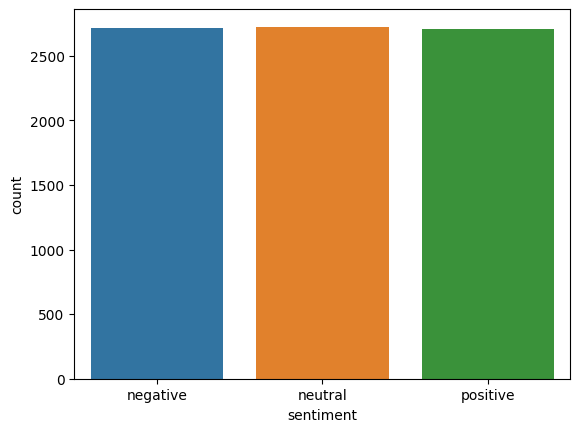

In [ ]:
sns.countplot(x = df.sentiment)

### Ví dụ thực hiện augment trên hàng đầu tiên của df


In [ ]:
# Tạo một DataFrame mới để lưu trữ các dòng mới
new_rows = []


row = df.iloc[0]
sentence = row['sentence']
print(sentence)
# Thực hiện đánh <mask>
sentence_mask = word_mask(sentence)
print(sentence_mask)
# Thực hiện hàm fill_mask
new_sentences = fill_mask(sentence_mask)

# Thực hiện translate_back
sentence_trans = translate_back(sentence)
print(sentence_trans)
new_sentences.append(translate_back(sentence))

# Tạo một dòng mới cho mỗi câu mới và thêm vào new_rows
for new_sentence in new_sentences:
    new_row = row.copy()
    new_row['sentence'] = new_sentence
    new_rows.append(new_row)
# Tạo một DataFrame từ new_rows
new_df = pd.DataFrame(new_rows)
new_df

Đội ngũ bảo trì quá thưa thớt dẫn đến không đảm bảo được chất lượng sửa chữa thiết bị.
 <mask> bảo_trì quá thưa_thớt dẫn đến không đảm_bảo được chất_lượng sửa_chữa thiết_bị .
Đội ngũ bảo trì quá thưa nên không thể đảm bảo chất lượng bảo trì thiết bị.


,sentence,sentiment,topic
0,Nhân viên bảo trì quá thưa thớt dẫn đến không ...,negative,facility
0,Lực lượng bảo trì quá thưa thớt dẫn đến không ...,negative,facility
0,Công tác bảo trì quá thưa thớt dẫn đến không đ...,negative,facility
0,Tần suất bảo trì quá thưa thớt dẫn đến không đ...,negative,facility
0,Quỹ bảo trì quá thưa thớt dẫn đến không đảm bả...,negative,facility
0,Đội ngũ bảo trì quá thưa nên không thể đảm bảo...,negative,facility


In [ ]:
print(new_rows)

[sentence     Nhân viên bảo trì quá thưa thớt dẫn đến không ...
sentiment                                             negative
topic                                                 facility
Name: 0, dtype: object, sentence     Lực lượng bảo trì quá thưa thớt dẫn đến không ...
sentiment                                             negative
topic                                                 facility
Name: 0, dtype: object, sentence     Công tác bảo trì quá thưa thớt dẫn đến không đ...
sentiment                                             negative
topic                                                 facility
Name: 0, dtype: object, sentence     Tần suất bảo trì quá thưa thớt dẫn đến không đ...
sentiment                                             negative
topic                                                 facility
Name: 0, dtype: object, sentence     Quỹ bảo trì quá thưa thớt dẫn đến không đảm bả...
sentiment                                             negative
topic                

### Thực hiện augment trên toàn bộ 8144 câu của df

In [ ]:
# Tạo một DataFrame mới để lưu trữ các dòng mới
new_rows = []

for i, row in tqdm(df.iterrows()):
    sentence = row['sentence']

    # Thực hiện đánh <mask>
    sentence_mask = word_mask(sentence)

    # Thực hiện hàm fill_mask
    new_sentences = fill_mask(sentence_mask)

    # Thực hiện translate_back
    new_sentences.append(translate_back(sentence))

    # Tạo một dòng mới cho mỗi câu mới và thêm vào new_rows
    for new_sentence in new_sentences:
        new_row = row.copy()
        new_row['sentence'] = new_sentence
        new_rows.append(new_row)




8144it [1:11:33,  1.90it/s]


### Nối data cũ và data mới được làm giàu

In [ ]:
# Tạo một DataFrame từ new_rows
new_df = pd.DataFrame(new_rows)

# Nối df và new_df
df = pd.concat([df, new_df], ignore_index=True)
df

,sentence,sentiment,topic
0,Đội ngũ bảo trì quá thưa thớt dẫn đến không đả...,negative,facility
1,The university's musical and artistic faciliti...,neutral,facility
2,Phương pháp giảng dạy phù hợp với các đối tượn...,neutral,curriculum
3,Chương trình học giúp tôi trở thành một chuyên...,positive,curriculum
4,Tôi nghĩ rằng chương trình đào tạo có thể có t...,neutral,curriculum
...,...,...,...
57002,Tôi cần chuyển sang học tại đại học khác để đá...,negative,curriculum
57003,Tôi cần chuyển sang học tại đại học khác để đá...,negative,curriculum
57004,Tôi cần chuyển sang học tại đại học khác để đá...,negative,curriculum
57005,Tôi cần chuyển sang học tại đại học khác để đá...,negative,curriculum


In [ ]:
augment_dir = os.path.join(base_dir, 'augment')

if not os.path.exists(augment_dir):
    os.makedirs(augment_dir)

df.to_csv(augment_dir + '/augment_synthetic_train.csv', index=False)